<a href="https://colab.research.google.com/github/rafio-iut/Vegetable-Classification-and-Quality-Assessment/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Environment

## Install Packages

In [53]:
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchsummary import summary

import math
import time
import random
import os
import shutil
import copy
import itertools
import dotenv

## Random Seed

In [55]:
random_state = 112

random = random.Random(random_state)
torch.manual_seed(random_state)

## Setup GPU

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load Environment Variables

In [57]:
dotenv.load_dotenv('.env')
github_token = os.getenv('GITHUB_TOKEN')

## Clone Repository

In [58]:
!rm -r *
!git clone https://{github_token}@github.com/rafio-iut/Vegetable-Classification-and-Quality-Assessment.git
!mv Vegetable-Classification-and-Quality-Assessment/* .
!rm -r Vegetable-Classification-and-Quality-Assessment

Cloning into 'Vegetable-Classification-and-Quality-Assessment'...
remote: Enumerating objects: 6228, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 6228 (delta 22), reused 23 (delta 8), pack-reused 6176
Receiving objects: 100% (6228/6228), 144.86 MiB | 22.86 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Updating files: 100% (6155/6155), done.


## Explode Directories

In [59]:
root_dir = '/content/New VegNet'

for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)

    if os.path.isdir(folder_path):
        for subfolder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if os.path.isdir(subfolder_path):
                new_folder_name = folder_name + ' - ' + subfolder_name
                new_folder_name = new_folder_name.split('. ')[1]
                new_folder_path = os.path.join(root_dir, new_folder_name)

                os.makedirs(new_folder_path, exist_ok=True)

                for file_name in os.listdir(subfolder_path):
                    file_path = os.path.join(subfolder_path, file_name)
                    new_file_path = os.path.join(new_folder_path, file_name)
                    shutil.move(file_path, new_file_path)

                os.rmdir(subfolder_path)

## Delete Empty Folders

In [60]:
root_dir = '/content/New VegNet'

for root, dirs, files in os.walk(root_dir, topdown=False):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            if not os.listdir(folder_path):
                os.rmdir(folder_path)

## Options

In [61]:
skip_count = True

# Load Data

## Load Raw Dataset

In [62]:
root_dir = '/content/New VegNet'

raw_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transforms.ToTensor())
all_labels = raw_dataset.classes

print(all_labels)
print(len(raw_dataset))

['Bell Pepper - Damaged', 'Bell Pepper - Dried', 'Bell Pepper - Old', 'Bell Pepper - Ripe', 'Bell Pepper - Unripe', 'Chile Pepper - Damaged', 'Chile Pepper - Dried', 'Chile Pepper - Old', 'Chile Pepper - Ripe', 'Chile Pepper - Unripe', 'New Mexico Green Chile - Damaged', 'New Mexico Green Chile - Dried', 'New Mexico Green Chile - Old', 'New Mexico Green Chile - Ripe', 'New Mexico Green Chile - Unripe', 'Tomato - Damaged', 'Tomato - Old', 'Tomato - Ripe', 'Tomato - Unripe']
6150


## Shuffle Dataset

In [63]:
num_samples = len(raw_dataset)
shuffle_indices = list(range(num_samples))
random.shuffle(shuffle_indices)
print(shuffle_indices[:10])

raw_dataset = Subset(raw_dataset, shuffle_indices)

[4583, 462, 2220, 1070, 3713, 3853, 1979, 115, 4924, 1198]


# Display Dataset

## Utility Functions

In [64]:
def parse_label(label):
    words = label.split(" - ")
    if len(words) < 2:
        return None, None
    vegetable = words[0].strip()
    quality = words[1].strip()
    return vegetable, quality

def get_label_counts(dataset):
    targets = [target for _, target in dataset]

    counts = {}
    for target in targets:
        label = all_labels[target]
        if label in counts: counts[label] += 1
        else: counts[label] = 1

    return dict(sorted(counts.items()))

def get_label_images(dataset):
    label_images = {}
    for image, target in dataset:
        label = all_labels[target]
        if label not in label_images:
            label_images[label] = image
            if len(label_images) == len(all_labels): return dict(sorted(label_images.items()))

    return dict(sorted(label_images.items()))

In [65]:
all_vegetables = []
all_qualities = []

for label in all_labels:
    vegetable, quality = parse_label(label)
    if vegetable not in all_vegetables: all_vegetables.append(vegetable)
    if quality not in all_qualities: all_qualities.append(quality)

all_vegetables = sorted(all_vegetables)
all_qualities = sorted(all_qualities)

In [66]:
def display_counts(dataset, dataset_name):
    if skip_count: return
    label_counts = get_label_counts(dataset)

    df_table = pd.DataFrame(index=all_vegetables, columns=all_qualities)
    df_table.fillna(0, inplace=True)

    for label, count in label_counts.items():
        vegetable, quality = parse_label(label)
        df_table.loc[vegetable, quality] = count

    df_table.loc['Total'] = df_table.sum()
    df_table['Total'] = df_table.sum(axis=1)

    print(dataset_name)
    display(df_table)
    print()

In [67]:
def display_images(dataset, dataset_name):
    label_images = get_label_images(dataset)

    num_classes = len(label_images)
    num_cols = 5
    num_rows = math.ceil(num_classes / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))
    fig.suptitle(dataset_name, fontsize=16, fontweight='bold')

    for i, (label, image) in enumerate(label_images.items()):
        row = i // num_cols
        col = i % num_cols

        image = image.numpy().transpose(1, 2, 0)
        vegetable, quality = parse_label(label)

        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image)
        ax.set_title(vegetable, fontsize=12, fontweight='bold', pad=10)
        ax.axis('off')
        ax.text(0.5, -0.075, quality, transform=ax.transAxes, ha='center', fontsize=12)

    for i in range(len(label_images), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols

        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout(h_pad=2)
    plt.show()

## Display Counts

In [68]:
display_counts(raw_dataset, 'Raw Dataset')

## Display Images

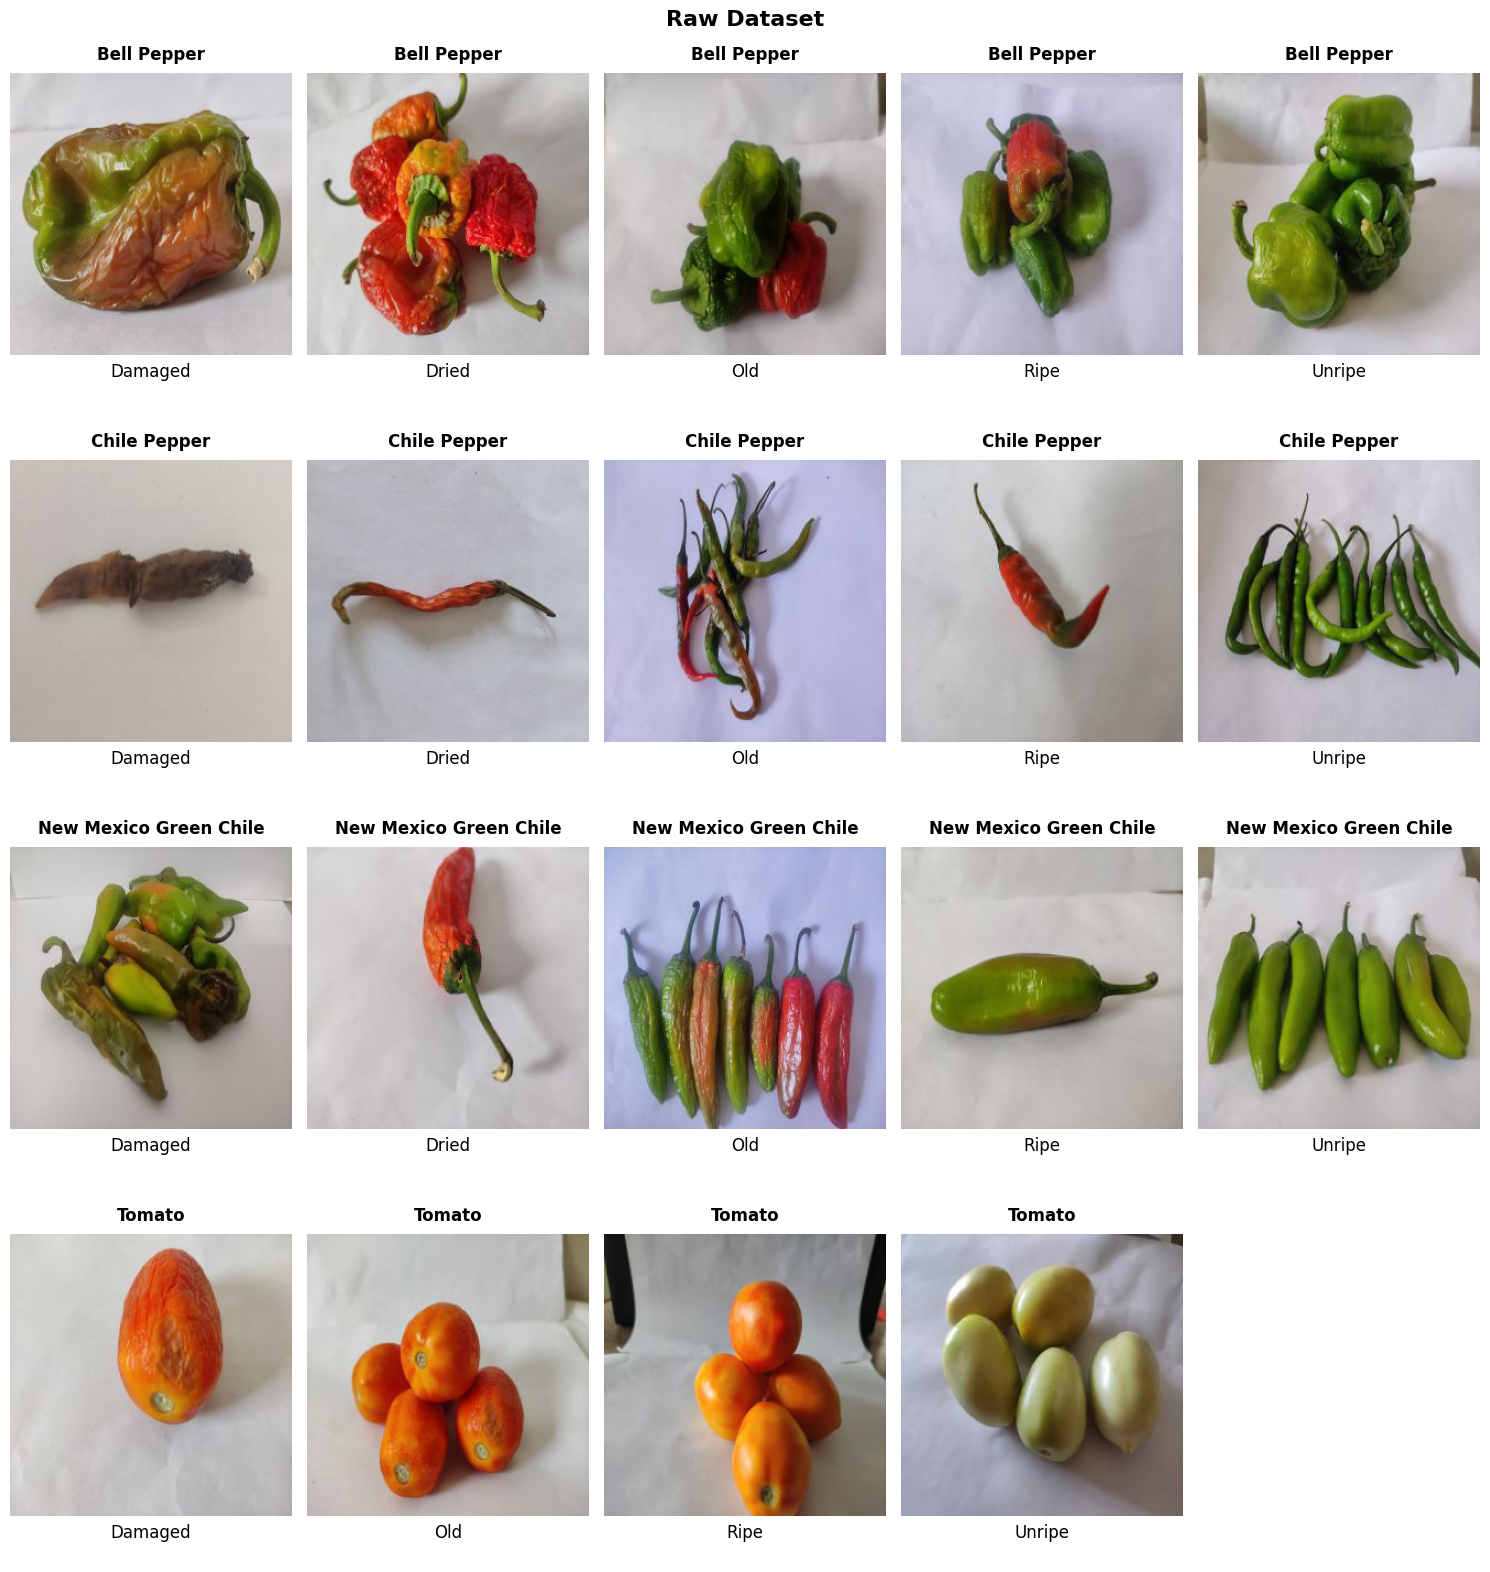

In [69]:
display_images(raw_dataset, 'Raw Dataset')

# Data Transformation

## Define Transformations

In [ ]:
transformations = [
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.ToTensor()
]

display_transformations = {
    'Random Rotation': transformations[0],
    'Random Horizontal Flip': transforms.RandomHorizontalFlip(1.0),
    'Random Vertical Flip': transforms.RandomVerticalFlip(1.0),
    'Random Jitter': transformations[3],
    'Random Shear': transformations[4],
    'Random Shift': transformations[5],
    'Random Scale': transformations[6]
}

## Display Transformations

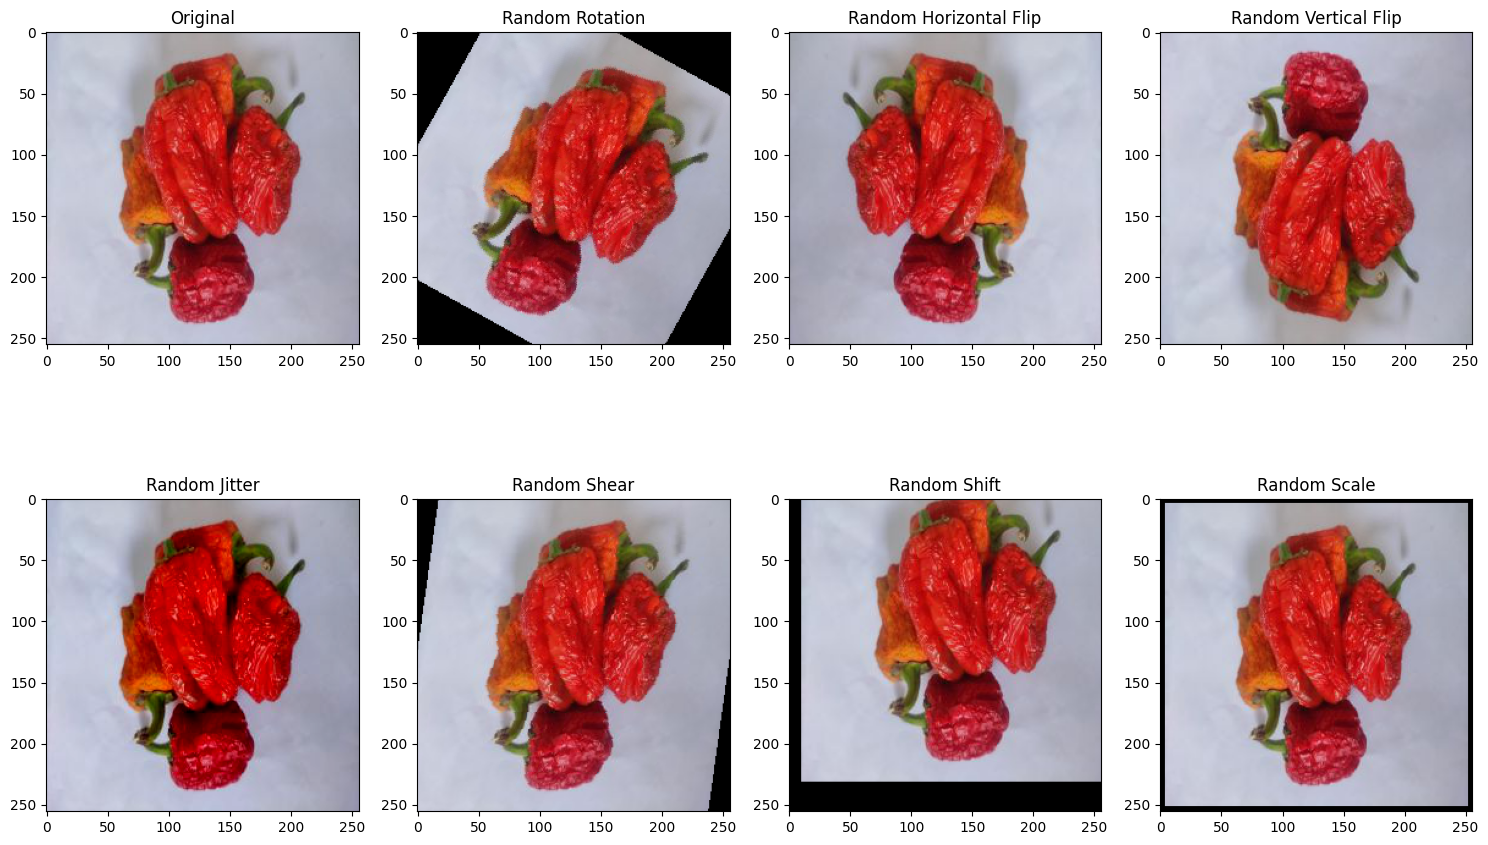

In [ ]:
random_index = random.randint(0, len(raw_dataset)-1)
sample_image, _ = raw_dataset[random_index]

num_transformations = len(display_transformations)
num_cols = 4
num_rows = math.ceil(num_transformations / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

image = sample_image.numpy().transpose(1, 2, 0)
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original')

for i, (title, transform) in enumerate(display_transformations.items()):
    transformed_image = transform(sample_image)
    image = transformed_image.numpy().transpose(1, 2, 0)
    row = (i + 1) // num_cols
    col = (i + 1) % num_cols
    axes[row, col].imshow(image)
    axes[row, col].set_title(title)

for i in range(num_transformations + 1, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Create Transformed Dataset

In [ ]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        if isinstance(dataset, Subset):
            self.dataset = dataset.dataset
            self.indices = dataset.indices
        else:
            self.dataset = dataset
            self.indices = range(len(dataset))

        self.transform = transform
        self.to_pil = transforms.ToPILImage()

        original_attrs = vars(self.dataset)
        for attr_name, attr_value in original_attrs.items():
            if not hasattr(self, attr_name):
                setattr(self, attr_name, attr_value)

        original_methods = [method_name for method_name in dir(self.dataset) if callable(getattr(self.dataset, method_name))]
        for method_name in original_methods:
            if not hasattr(self, method_name):
                method = getattr(self.dataset, method_name)
                setattr(self, method_name, method)

    def __getitem__(self, index):
        image, label = self.dataset[self.indices[index]]
        image = self.to_pil(image)
        transformed_image = self.transform(image)
        return transformed_image, label

    def __len__(self):
        return len(self.indices)


transformed_dataset = TransformedDataset(raw_dataset, transforms.Compose(transformations))

## Display Dataset

Transformed Dataset


Damaged  Dried   Old  Ripe  Unripe  Total
Bell Pepper                  31    296   349   448      52   1176
Chile Pepper                121    593   200   183     189   1286
New Mexico Green Chile      138    500   261   201     227   1327
Tomato                       27      0  1234   955     145   2361
Total                       317   1389  2044  1787     613   6150

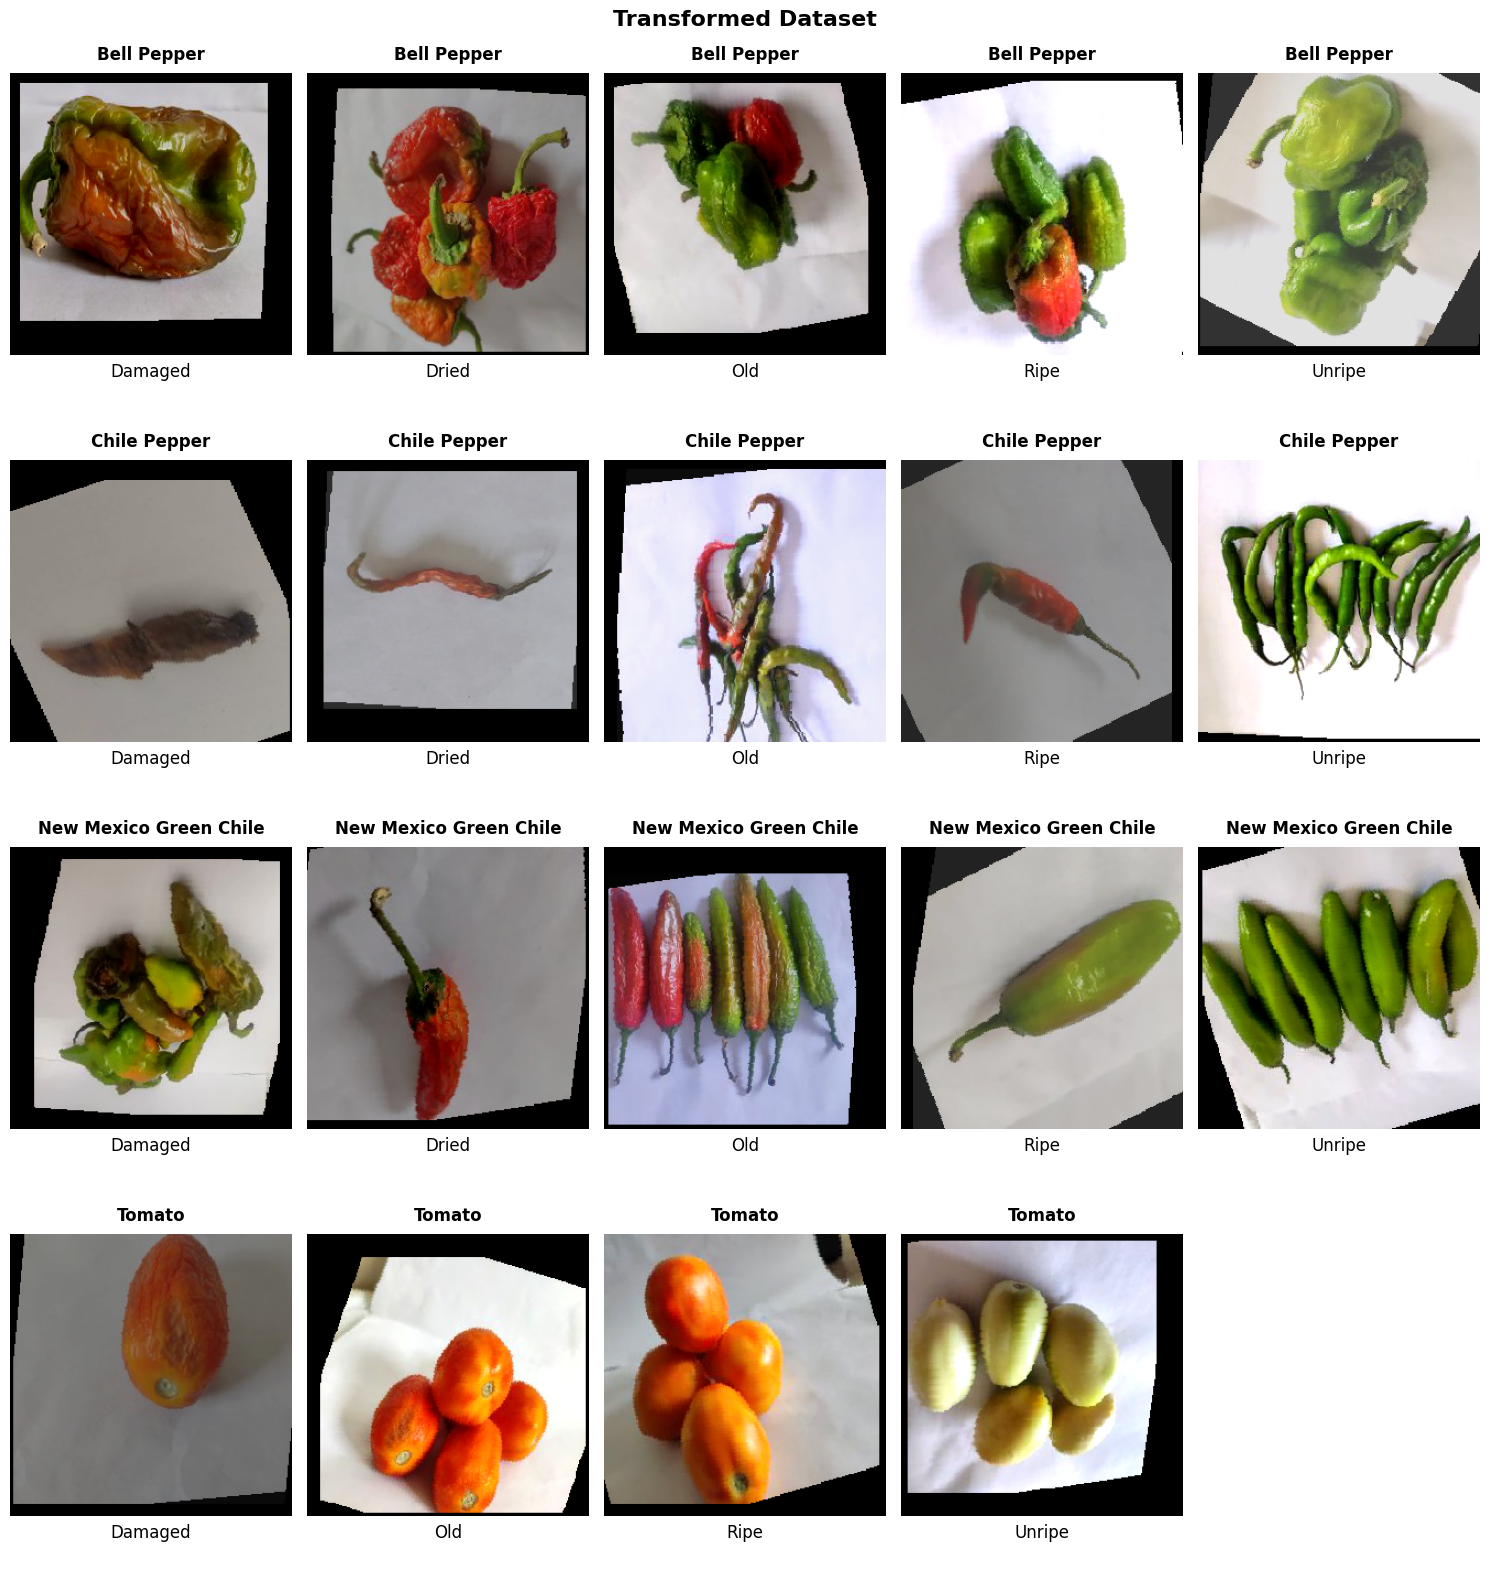

In [ ]:
display_counts(transformed_dataset, 'Transformed Dataset')
display_images(transformed_dataset, 'Transformed Dataset')

# K-Fold Cross Validation

## Utility Functions

In [ ]:
def balance_classes(dataset):
    if isinstance(dataset, Subset):
        original_dataset = dataset.dataset
        dataset_indices = dataset.indices
    else:
        original_dataset = dataset
        dataset_indices = range(len(dataset))

    num_classes = len(original_dataset.classes)
    class_indices = [[] for _ in range(num_classes)]
    class_counts = [0] * num_classes

    for index in dataset_indices:
        _, target = original_dataset[index]
        class_indices[target].append(index)
        class_counts[target] += 1

    max_count = max(class_counts)

    duplicates = []

    for target, count in enumerate(class_counts):
        while count < max_count:
            duplicate_index = random.choice(class_indices[target])
            duplicates.append(duplicate_index)
            count += 1

    balanced_indices = list(dataset_indices) + duplicates
    balanced_dataset = Subset(original_dataset, balanced_indices)

    return balanced_dataset

def generate_subsets(dataset, k):
    if isinstance(dataset, Subset):
        original_dataset = dataset.dataset
        dataset_indices = dataset.indices
    else:
        original_dataset = dataset
        dataset_indices = range(len(dataset))

    num_classes = len(original_dataset.classes)
    class_indices = [[] for _ in range(num_classes)]
    class_counts = [0] * num_classes

    subset_class_counts = [[0] * k for _ in range(num_classes)]
    subset_indices = [[] for _ in range(k)]
    subsets = []

    for index in dataset_indices:
        _, target = original_dataset[index]
        target_counts = subset_class_counts[target]

        candidate_subsets = []
        for i in range(k):
            if len(candidate_subsets) == 0: candidate_subsets.append(i)
            else:
                min_count = target_counts[candidate_subsets[0]]
                if target_counts[i] == min_count: candidate_subsets.append(i)
                elif target_counts[i] < min_count: candidate_subsets = [i]

        selected_subset = random.choice(candidate_subsets)
        subset_indices[selected_subset].append(index)
        subset_class_counts[target][selected_subset] += 1

    for indices in subset_indices:
        random.shuffle(indices)
        subsets.append(Subset(original_dataset, indices))

    return subsets

## Prepare Subsets

In [ ]:
k = 5
plain_subset = generate_subsets(transformed_dataset, k)

balanced_subset = []
for i in range(k): balanced_subset.append(balance_classes(plain_subset[i]))

In [ ]:
for i, subset in enumerate(plain_subset): display_counts(subset, f'Subset {i+1}')
for i, subset in enumerate(balanced_subset): display_counts(subset, f'Balanced Subset {i+1}')

Subset 1


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   6     59   69    90      11    235
Chile Pepper                 24    119   40    36      38    257
New Mexico Green Chile       28    100   52    40      46    266
Tomato                        5      0  246   191      29    471
Total                        63    278  407   357     124   1229


Subset 2


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   6     60   70    89      10    235
Chile Pepper                 24    119   40    36      38    257
New Mexico Green Chile       27    100   52    40      46    265
Tomato                        5      0  247   191      29    472
Total                        62    279  409   356     123   1229


Subset 3


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   6     59   70    90      10    235
Chile Pepper                 24    118   40    37      38    257
New Mexico Green Chile       28    100   52    41      45    266
Tomato                        6      0  247   191      29    473
Total                        64    277  409   359     122   1231


Subset 4


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   6     59   70    89      11    235
Chile Pepper                 25    119   40    37      38    259
New Mexico Green Chile       27    100   53    40      45    265
Tomato                        5      0  247   191      29    472
Total                        63    278  410   357     123   1231


Subset 5


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   7     59   70    90      10    236
Chile Pepper                 24    118   40    37      37    256
New Mexico Green Chile       28    100   52    40      45    265
Tomato                        6      0  247   191      29    473
Total                        65    277  409   358     121   1230


Balanced Subset 1


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 246    246  246   246     246   1230
Chile Pepper                246    246  246   246     246   1230
New Mexico Green Chile      246    246  246   246     246   1230
Tomato                      246      0  246   246     246    984
Total                       984    738  984   984     984   4674


Balanced Subset 2


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 247    247  247   247     247   1235
Chile Pepper                247    247  247   247     247   1235
New Mexico Green Chile      247    247  247   247     247   1235
Tomato                      247      0  247   247     247    988
Total                       988    741  988   988     988   4693


Balanced Subset 3


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 247    247  247   247     247   1235
Chile Pepper                247    247  247   247     247   1235
New Mexico Green Chile      247    247  247   247     247   1235
Tomato                      247      0  247   247     247    988
Total                       988    741  988   988     988   4693


Balanced Subset 4


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 247    247  247   247     247   1235
Chile Pepper                247    247  247   247     247   1235
New Mexico Green Chile      247    247  247   247     247   1235
Tomato                      247      0  247   247     247    988
Total                       988    741  988   988     988   4693


Balanced Subset 5


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 247    247  247   247     247   1235
Chile Pepper                247    247  247   247     247   1235
New Mexico Green Chile      247    247  247   247     247   1235
Tomato                      247      0  247   247     247    988
Total                       988    741  988   988     988   4693

In [ ]:
def get_data_splits(plain_subset, balanced_subset, test_index):
    data_split = {}

    testset = plain_subset[test_index]
    trainvalset = ConcatDataset(balanced_subset[:test_index] + balanced_subset[test_index+1:])

    train_size = int(0.8 * len(trainvalset))
    val_size = len(trainvalset) - train_size
    trainset, valset = random_split(trainvalset, [train_size, val_size])

    data_split['Train'] = trainset
    data_split['Val'] = valset
    data_split['Test'] = testset
    for phase in ['Train', 'Val', 'Test']: display_counts(data_split[phase], f'{phase}-set {test_index + 1}')

    return data_split

## Prepare Data Loaders

In [ ]:
k = 5
data_splits = []
dataloaders = []

for i in range(k):
    print(f'Preparing Test {i+1}')
    print('-' * 20)
    print()

    split = get_data_splits(plain_subset, balanced_subset, i)
    loader = {x: torch.utils.data.DataLoader(split[x], batch_size=32, shuffle=True, num_workers=2)
                      for x in ['Train', 'Val', 'Test']}
    data_splits.append(split)
    dataloaders.append(loader)

Preparing Test 1
--------------------

Train-set 1


Damaged  Dried   Old  Ripe  Unripe  Total
Bell Pepper                 801    780   801   789     793   3964
Chile Pepper                814    778   783   769     782   3926
New Mexico Green Chile      794    773   803   800     758   3928
Tomato                      800      0   790   806     803   3199
Total                      3209   2331  3177  3164    3136  15017


Val-set 1


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 187    208  187   199     195    976
Chile Pepper                174    210  205   219     206   1014
New Mexico Green Chile      194    215  185   188     230   1012
Tomato                      188      0  198   182     185    753
Total                       743    633  775   788     816   3755


Test-set 1


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   6     59   69    90      11    235
Chile Pepper                 24    119   40    36      38    257
New Mexico Green Chile       28    100   52    40      46    266
Tomato                        5      0  246   191      29    471
Total                        63    278  407   357     124   1229


Preparing Test 2
--------------------

Train-set 2


Damaged  Dried   Old  Ripe  Unripe  Total
Bell Pepper                 787    770   786   805     791   3939
Chile Pepper                771    770   774   803     815   3933
New Mexico Green Chile      809    787   783   792     790   3961
Tomato                      797      0   805   788     779   3169
Total                      3164   2327  3148  3188    3175  15002


Val-set 2


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 200    217  201   182     196    996
Chile Pepper                216    217  213   184     172   1002
New Mexico Green Chile      178    200  204   195     197    974
Tomato                      190      0  182   199     208    779
Total                       784    634  800   760     773   3751


Test-set 2


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   6     60   70    89      10    235
Chile Pepper                 24    119   40    36      38    257
New Mexico Green Chile       27    100   52    40      46    265
Tomato                        5      0  247   191      29    472
Total                        62    279  409   356     123   1229


Preparing Test 3
--------------------

Train-set 3


Damaged  Dried   Old  Ripe  Unripe  Total
Bell Pepper                 787    794   793   790     789   3953
Chile Pepper                772    780   809   793     792   3946
New Mexico Green Chile      798    768   790   811     785   3952
Tomato                      787      0   786   798     780   3151
Total                      3144   2342  3178  3192    3146  15002


Val-set 3


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 200    193  194   197     198    982
Chile Pepper                215    207  178   194     195    989
New Mexico Green Chile      189    219  197   176     202    983
Tomato                      200      0  201   189     207    797
Total                       804    619  770   756     802   3751


Test-set 3


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   6     59   70    90      10    235
Chile Pepper                 24    118   40    37      38    257
New Mexico Green Chile       28    100   52    41      45    266
Tomato                        6      0  247   191      29    473
Total                        64    277  409   359     122   1231


Preparing Test 4
--------------------

Train-set 4


Damaged  Dried   Old  Ripe  Unripe  Total
Bell Pepper                 774    801   796   752     795   3918
Chile Pepper                796    789   812   792     778   3967
New Mexico Green Chile      790    801   789   794     788   3962
Tomato                      781      0   767   804     803   3155
Total                      3141   2391  3164  3142    3164  15002


Val-set 4


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 213    186  191   235     192   1017
Chile Pepper                191    198  175   195     209    968
New Mexico Green Chile      197    186  198   193     199    973
Tomato                      206      0  220   183     184    793
Total                       807    570  784   806     784   3751


Test-set 4


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   6     59   70    89      11    235
Chile Pepper                 25    119   40    37      38    259
New Mexico Green Chile       27    100   53    40      45    265
Tomato                        5      0  247   191      29    472
Total                        63    278  410   357     123   1231


Preparing Test 5
--------------------

Train-set 5


Damaged  Dried   Old  Ripe  Unripe  Total
Bell Pepper                 788    784   786   804     770   3932
Chile Pepper                773    793   791   778     810   3945
New Mexico Green Chile      804    791   774   791     787   3947
Tomato                      786      0   784   796     812   3178
Total                      3151   2368  3135  3169    3179  15002


Val-set 5


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                 199    203  201   183     217   1003
Chile Pepper                214    194  196   209     177    990
New Mexico Green Chile      183    196  213   196     200    988
Tomato                      201      0  203   191     175    770
Total                       797    593  813   779     769   3751


Test-set 5


Damaged  Dried  Old  Ripe  Unripe  Total
Bell Pepper                   7     59   70    90      10    236
Chile Pepper                 24    118   40    37      37    256
New Mexico Green Chile       28    100   52    40      45    265
Tomato                        6      0  247   191      29    473
Total                        65    277  409   358     121   1230

# Train Models

## Utility Functions

In [ ]:
def run_step(data_split, dataloader, model, preprocess, criterion, optimizer, phase):
    running_loss = 0.0
    correct_counts = 0

    for batch_image, batch_target in dataloader[phase]:
        batch_image = [preprocess(image) for image in batch_image]
        batch_image = torch.stack(batch_image)
        batch_image = batch_image.to(device)
        batch_target = batch_target.to(device)

        with torch.set_grad_enabled(phase == 'Train'):
            batch_output = model(batch_image)
            _, batch_prediction = torch.max(batch_output, 1)
            loss = criterion(batch_output, batch_target)

            if phase == 'Train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * batch_image.size(0)
        correct_counts += torch.sum(batch_prediction == batch_target)

    step_loss = running_loss / len(data_split[phase])
    step_acc = correct_counts.double() / len(data_split[phase])

    return step_loss, step_acc

def train_model(data_split, dataloader, model, preprocess, hyperparameters):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    criterion, learning_rate, momentum, scheduler_step_size, gamma = (
        hyperparameters['loss_function'],
        hyperparameters['learning_rate'],
        hyperparameters['momentum'],
        hyperparameters['scheduler_step_size'],
        hyperparameters['gamma']
    )
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=gamma)
    num_epochs = hyperparameters.get('num_epochs', 1)

    for epoch in range(1, num_epochs + 1, 1):
        print(f'Running Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()
            else:
                model.eval()

            step_loss, step_acc = run_step(data_split, dataloader, model, preprocess, criterion, optimizer, phase)
            print(f'{phase} Loss: {step_loss:.4f}, Acc: {step_acc:.2%}')

            if phase == 'Val' and step_acc > best_acc:
                best_acc = step_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if phase == 'Train':
            scheduler.step()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc * 100:.2f}%')
    print()

    model.load_state_dict(best_model_wts)
    return model

def train_model_kfold(model, preprocess, k=5, hyperparameters=None):
    required_hyperparameters = ['learning_rate', 'momentum', 'scheduler_step_size', 'gamma']
    missing_hyperparameters = [key for key in required_hyperparameters if key not in hyperparameters]

    if not hyperparameters or missing_hyperparameters:
        missing_hyperparameter_str = ", ".join(missing_hyperparameters)
        raise ValueError(f'Missing required hyperparameters: {missing_hyperparameter_str}')

    for key in required_hyperparameters:
        if not isinstance(hyperparameters[key], (int, float)):
            raise TypeError(f"Invalid type for hyperparameter '{key}'")

    base_state = copy.deepcopy(model.state_dict())
    trained_models = []

    for test_index in range(k):
        model.load_state_dict(base_state)
        print(f'Training for Test {test_index + 1}')
        print('-' * 20)
        print()

        data_split = data_splits[test_index]
        dataloader = dataloaders[test_index]

        model = train_model(data_split, dataloader, model, preprocess, hyperparameters)
        trained_models.append(copy.deepcopy(model))

    return trained_models

## Run Training

### ResNet-50

In [ ]:
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
preprocess = weights.transforms(antialias=None)

model.fc = nn.Linear(model.fc.in_features, len(all_labels))
model = model.to(device)

resize_size = preprocess.resize_size[0]
input_size = (3, resize_size, resize_size)
summary(model, input_size)

In [ ]:
hyperparameters = {
    'loss_function': nn.CrossEntropyLoss(),
    'learning_rate': 0.001,
    'momentum': 0.9,
    'scheduler_step_size': 7,
    'gamma': 0.1,
    'num_epochs': 2
}

resnet50_models = train_model_kfold(model, preprocess, hyperparameters=hyperparameters, k=5)

### AlexNet

In [ ]:
weights = models.AlexNet_Weights.IMAGENET1K_V1
model = models.alexnet(weights=weights)
preprocess = weights.transforms(antialias=None)

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(all_labels))
model = model.to(device)

resize_size = preprocess.resize_size[0]
input_size = (3, resize_size, resize_size)
summary(model, input_size)

In [ ]:
hyperparameters = {
    'loss_function': nn.CrossEntropyLoss(),
    'learning_rate': 0.001,
    'momentum': 0.9,
    'scheduler_step_size': 7,
    'gamma': 0.1
}

alexnet_models = train_model_kfold(model, preprocess, k=5, hyperparameters=hyperparameters)

### DenseNet-169

In [ ]:
weights = models.DenseNet169_Weights.IMAGENET1K_V1
model = models.densenet169(weights=weights)
preprocess = weights.transforms(antialias=None)

model.classifier = nn.Linear(model.classifier.in_features, len(all_labels))
model = model.to(device)

In [ ]:
hyperparameters = {
    'loss_function': nn.CrossEntropyLoss(),
    'learning_rate': 0.001,
    'momentum': 0.9,
    'scheduler_step_size': 7,
    'gamma': 0.1
}

densenet169_models = train_model_kfold(model, preprocess, k=5, hyperparameters=hyperparameters)

# Evaluate Models

## Setup DataFrame

In [70]:
def to_percentage(x):
    return f'{x*100:.2f}%'

def from_percentage(percentage):
    percentage = percentage.rstrip('%')
    try:
        decimal = float(percentage) / 100
        return decimal
    except ValueError:
        raise ValueError("Invalid Format")

k = 5
results_df = pd.DataFrame(columns=['Model'] + [f'Test-{i+1} Accuracy' for i in range(k)] + ['Average Accuracy'])

## Utility Functions

In [174]:
def get_targets_predictions(model, dataloader):
    targets = []
    predictions = []

    for batch_image, batch_target in dataloader:
        batch_image = [preprocess(image) for image in batch_image]
        batch_image = torch.stack(batch_image)
        batch_image = batch_image.to(device)
        batch_target = batch_target.to(device)

        batch_output = model(batch_image)
        _, batch_prediction = torch.max(batch_output, 1)

        targets.extend(batch_target.cpu().numpy())
        predictions.extend(batch_prediction.cpu().numpy())

    return targets, predictions

def parse_targets(targets):
    target_attributes = {'Label': [], 'Vegetable': [], 'Quality': []}

    for target in targets:
        label = all_labels[target]
        vegetable, quality = parse_label(label)

        target_attributes['Label'].append(label)
        target_attributes['Vegetable'].append(vegetable)
        target_attributes['Quality'].append(quality)

    return target_attributes

def filter_labels(labels):
    filtered_labels = []
    for label in labels:
        label = label.replace(' - ', ' ')
        words = label.split()

        pair_of_words = [f'{words[i]} {words[i+1]}' if i < len(words) - 1 else words[i] for i in range(0, len(words), 2)]
        filtered_label = '\n'.join(pair_of_words)

        filtered_labels.append(filtered_label)

    return filtered_labels

In [173]:
def calculate_metrics(targets, predictions, labels, confusion_matrix):
    precision_values = []
    recall_values = []
    f1_score_values = []
    specificity_values = []

    for i in range(len(labels)):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp
        tn = np.sum(confusion_matrix) - tp - fp - fn

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        precision_values.append(precision)
        recall_values.append(recall)
        f1_score_values.append(f1_score)
        specificity_values.append(specificity)

    metrics_df = pd.DataFrame(index=['Precision', 'Recall', 'F1 Score', 'Specificity'], columns=labels)
    metrics_df.loc['Precision'] = precision_values
    metrics_df.loc['Recall'] = recall_values
    metrics_df.loc['F1 Score'] = f1_score_values
    metrics_df.loc['Specificity'] = specificity_values

    return metrics_df

def generate_confusion_matrix(targets, predictions, labels):
    targets = filter_labels(targets)
    predictions = filter_labels(predictions)
    labels = filter_labels(labels)

    label_indices = {label: index for index, label in enumerate(labels)}
    num_labels = len(labels)

    confusion_matrix = np.zeros((num_labels, num_labels), dtype=np.int32)

    for target, prediction in zip(targets, predictions):
        target_index = label_indices[target]
        prediction_index = label_indices[prediction]
        confusion_matrix[target_index, prediction_index] += 1

    confusion_df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    correct_count = np.diag(confusion_matrix).sum()
    metrics_df = calculate_metrics(targets, predictions, labels, confusion_matrix).astype(float).round(2)

    return confusion_df, metrics_df, correct_count

def display_matrices(test_index, confusion_matrices, metrics_tables, correct_counts, total_count):
    matrices = [
        confusion_matrices['Label'], metrics_tables['Label'],
        confusion_matrices['Vegetable'], metrics_tables['Vegetable'],
        confusion_matrices['Quality'], metrics_tables['Quality']
    ]

    plt.figure(figsize=(25, 50))
    colspans = [2, 2, 1, 1, 1, 1]
    rowspans = [2, 1, 1, 1, 1, 1]
    plot_arrangements = [(0, 0),
        (rowspans[0], 0),
        (rowspans[0]+rowspans[1], 0),
        (rowspans[0]+rowspans[1]+rowspans[2], 0),
        (rowspans[0]+rowspans[1], 1),
        (rowspans[0]+rowspans[1]+rowspans[2], 1)
    ]
    contexts = ['Label', 'Vegetable', 'Quality']

    for i, plot_arrangement in enumerate(plot_arrangements):
        plt.subplot2grid((5, 2), plot_arrangement, colspan=colspans[i], rowspan=rowspans[i])
        heatmap = sns.heatmap(matrices[i], annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"fontsize": 16})
        heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, rotation=45)
        heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, rotation=0)

        if i % 2 == 0:
            plt.xlabel('Predicted', fontsize=16)
            plt.ylabel('Actual', fontsize=16)
            plt.title(f'Confusion Matrix ({contexts[i//2]}), Accuracy: {correct_counts[contexts[i//2]]}/{total_count} = {correct_counts[contexts[i//2]] / total_count:.2%}', fontsize=18)
        else:
            plt.title(f'Metrics ({contexts[i//2]})', fontsize=18)

    plt.suptitle(f'Test-{test_index + 1} Results', fontsize=24)
    plt.tight_layout(pad=4.0)
    plt.show()

In [122]:
def evaluate(test_index, model, dataloader):
    since = time.time()

    print(f'Evaluating on Test {test_index+1}')
    print('-' * 20)
    print()

    targets, predictions = get_targets_predictions(model, dataloader)
    total_count = len(targets)

    target_attributes = parse_targets(targets)
    predicted_attributes = parse_targets(predictions)
    all_values = {
        'Label': all_labels,
        'Vegetable': all_vegetables,
        'Quality': all_qualities
    }

    contexts = ['Label', 'Vegetable', 'Quality']
    confusion_matrices = {}
    metrics_tables = {}
    correct_counts = {}

    for context in contexts:
        print(f'Matching {context}')
        print('-' * 10)

        target_values = target_attributes[context]
        predicted_values = predicted_attributes[context]

        confusion_matrices[context], metrics_tables[context], correct_counts[context] = generate_confusion_matrix(
            target_values,
            predicted_values,
            all_values[context]
        )

    print('Generating Confusion Matrices')
    print('-' * 10)
    display_matrices(test_index, confusion_matrices, metrics_tables, correct_counts, total_count, 'Confusion Matrix')

    time_elapsed = time.time() - since
    print(f'Evaluation complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print()

    return correct_counts['Label']/total_count

## Run Evaluation

### ResNet-50

In [ ]:
model_name = 'ResNet-50'

result = {'Model': model_name}
for test_index, model in enumerate(resnet50_models):
    acc = evaluate(test_index, model, dataloaders[test_index]['Test'])
    result[f'Test-{test_index + 1} Accuracy'] = acc

results_df = pd.concat([results_df, pd.DataFrame(result, index=[0])], ignore_index=True)

### AlexNet

In [ ]:
model_name = 'AlexNet'

result = {'Model': model_name}
for test_index, model in enumerate(alexnet_models):
    acc = evaluate(test_index, model, dataloaders[test_index]['Test'])
    result[f'Test-{test_index + 1} Accuracy'] = acc

results_df = pd.concat([results_df, pd.DataFrame(result, index=[0])], ignore_index=True)

### DenseNet-169

In [ ]:
model_name = 'DenseNet-169'

result = {'Model': model_name}
for test_index, model in enumerate(densenet169_models):
    acc = evaluate(test_index, model, dataloaders[test_index]['Test'])
    result[f'Test-{test_index + 1} Accuracy'] = acc

results_df = pd.concat([results_df, pd.DataFrame(result, index=[0])], ignore_index=True)

# View Results

## Calculate Average Accuracy

In [ ]:
results_df['Average Accuracy'] = results_df.iloc[:, 1:].mean(axis=1)

## Display Results

In [ ]:
results_df['Average Accuracy'] = results_df['Average Accuracy'].map(to_percentage)
for i in range(k):
    results_df[f'Test-{i+1} Accuracy'] = results_df[f'Test-{i+1} Accuracy'].map(to_percentage)

display(results_df)

results_df['Average Accuracy'] = results_df['Average Accuracy'].map(from_percentage)
for i in range(k):
    results_df[f'Test-{i+1} Accuracy'] = results_df[f'Test-{i+1} Accuracy'].map(from_percentage)